# Source conditions for linear inverse problems

In [149]:
%matplotlib inline
from matplotlib.pyplot import colorbar, draw, gca, imshow, plot, savefig, subplot, tight_layout
from numpy import linspace, log, mean, ones, ones_like, prod, real, sqrt, \
                    vstack, where, zeros, zeros_like
from numpy import sum as numpy_sum
from numpy.fft import fft2, fftshift, ifft2, ifftshift
from numpy.linalg import norm
from numpy.random import randn
from optimisation import PALM, proximal_gradient_descent, PDHG
from proximal_maps import *
from skimage.color import rgb2gray
from skimage.data import astronaut, shepp_logan_phantom
from skimage import io, img_as_uint
from skimage.transform import resize
from operators import *

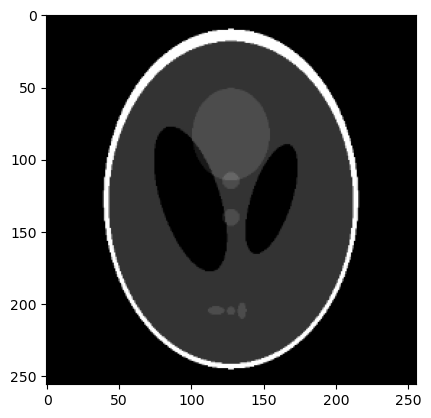

In [158]:
example = 'shepp_logan' # possible choices: 'shepp_logan', 'astronaut'

if example == 'shepp_logan':
    image = resize(shepp_logan_phantom(), (256, 256), anti_aliasing=True)
    imshow(image, cmap='gray');
    io.imsave('Data/Images/2DSC/shepp_logan_phantom.png', img_as_uint(image))
if example == 'astronaut':
    image = resize(rgb2gray(astronaut()), (512, 512), anti_aliasing=True)
    imshow(image, cmap='gray');
    io.imsave('Data/Images/2DSC/astronaut.png', img_as_uint(image))

In [159]:
print(image.shape)

(256, 256)


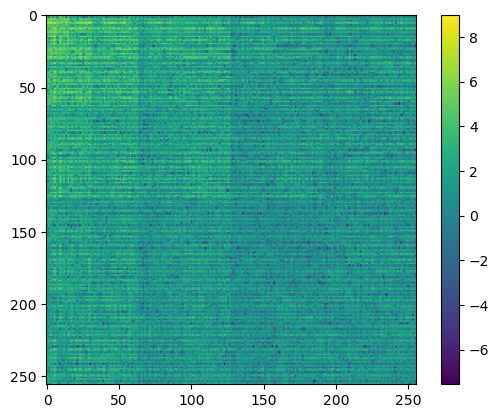

In [160]:
H = FWHT()
hadamard_image = H @ image.flatten()
visual_shift = 0.1/sqrt(image.shape[0]*image.shape[1])
imshow(log(visual_shift + abs(hadamard_image.reshape(image.shape))))
colorbar()
draw();

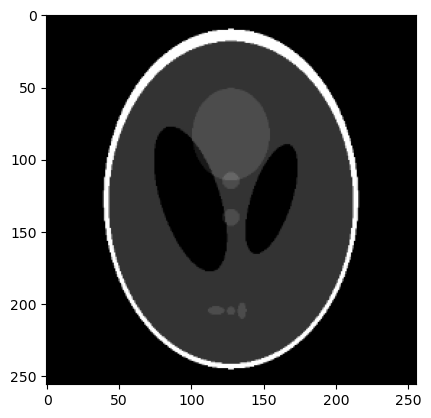

In [161]:
test = H.T @ hadamard_image
imshow(test.reshape(image.shape), cmap='gray');

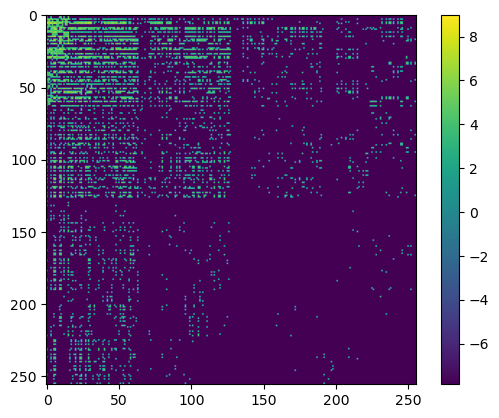

In [165]:
N = 5000  # Set N to the desired number of largest coefficients

# Flatten the image and get the absolute values of the coefficients
abs_coefficients = abs(hadamard_image.flatten())

# Find the indices of the N largest coefficients
largest_indices = abs_coefficients.argsort()[-N:]

# Set all coefficients to zero except for the largest N
hadamard_image_filtered = zeros_like(hadamard_image.flatten())
hadamard_image_filtered[largest_indices] = hadamard_image.flatten()[largest_indices]

imshow(log(visual_shift + abs(hadamard_image_filtered.reshape(image.shape))))
colorbar()
draw();

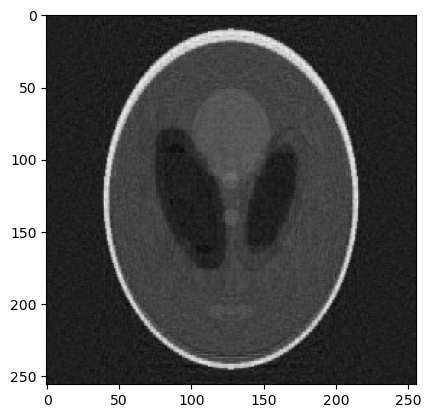

In [166]:
# Apply H.T to the filtered coefficients
test2 = (H.T @ hadamard_image_filtered).reshape(image.shape)

# Visualize the result
imshow(test2, cmap='gray');

# Learning the optimal sampling pattern

In [197]:
if example == 'shepp_logan':
    threshold = 4
if example == 'astronaut':
    threshold = 15

G = Difference_Gradient(image.shape)
finite_difference_image = G @ image
step_sizes = [1, 1/9]
proximal_map = lambda argument : argument - l2ball_projection(argument, axis=2)

l1_proximal_map = lambda argument : soft_thresholding(argument, threshold*step_sizes[1])
identity_proximal_map = lambda argument : argument
proximal_maps = [l1_proximal_map, identity_proximal_map]
bregman_gradient_1_new = lambda arguments: H @ (H.T @ arguments[0] - G.T @ arguments[1])
bregman_gradient_2_new = lambda arguments: G @ (G.T @ arguments[1] - H.T @ arguments[0]) + \
                        proximal_map(arguments[1] + finite_difference_image) - finite_difference_image
gradients = [bregman_gradient_1_new, bregman_gradient_2_new]

In [198]:
no_of_iterations = 2500
step_sizes = [1, 1/9]
palm_arguments = [zeros(image.shape), zeros((image.shape[0], \
                                image.shape[1], 2))]                
palm_arguments, norm_list = PALM(gradients, proximal_maps, palm_arguments, step_sizes, \
                            no_of_iterations, print_output=100)                      

Iteration 100/1000, sensitivity = 0.01003392049836081.
Iteration 200/1000, sensitivity = 0.004853800289534263.
Iteration 300/1000, sensitivity = 0.0031621604344905232.
Iteration 400/1000, sensitivity = 0.002246136136468195.
Iteration 500/1000, sensitivity = 0.0017587243441286311.
Iteration 600/1000, sensitivity = 0.00145378652521874.
Iteration 700/1000, sensitivity = 0.001238318518938754.
Iteration 800/1000, sensitivity = 0.0010767822826213708.
Iteration 900/1000, sensitivity = 0.0009504813025051792.
Iteration 1000/1000, sensitivity = 0.0008345720722085361.
Iteration completed after 1000/1000, sensitivity = 0.0008345720722085361.


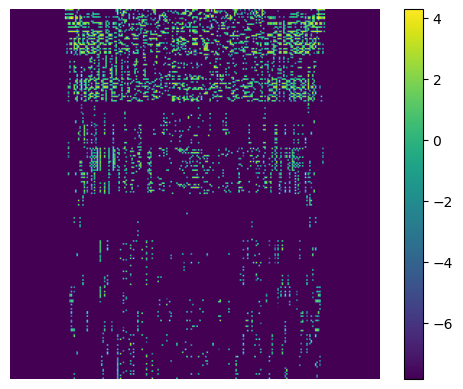

In [199]:
imshow(log(visual_shift + abs(palm_arguments[0])))
colorbar();
ax = gca()
ax.set_axis_off()
# Save image
if example == 'shepp_logan':
    path = 'Data/Images/2DSC/shepp_logan_sparse_sc.png'
if example == 'astronaut':
    path = 'Data/Images/2DSC/astronaut_sparse_sc.png'
savefig(path, dpi=None, facecolor='w', edgecolor='w',
        orientation='portrait', format='png',
        transparent=False, bbox_inches='tight', pad_inches=0.1)

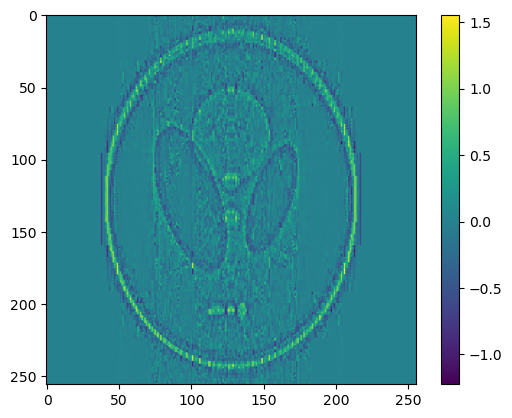

In [200]:
imshow(H.T @ palm_arguments[0])
colorbar();

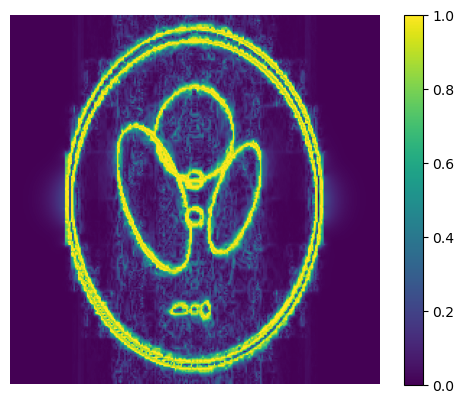

In [201]:
imshow(sqrt(palm_arguments[1][:, :, 0] ** 2 + palm_arguments[1][:, :, 1] ** 2), vmin=0, vmax=1)
colorbar();
ax = gca()
ax.set_axis_off()
# Save image
if example == 'shepp_logan':
    path = 'Data/Images/2DSC/shepp_logan_sparse_sc_subgradient.png'
if example == 'astronaut':
    path = 'Data/Images/2DSC/astronaut_sparse_sc_subgradient.png'
savefig(path, dpi=None, facecolor='w', edgecolor='w',
        orientation='portrait', format='png',
        transparent=False, bbox_inches='tight', pad_inches=0.1)

840.1717996171578
4589 5000


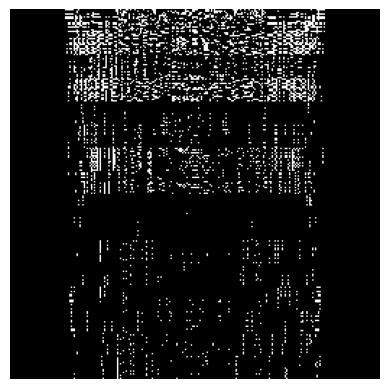

In [202]:
new_source_condition_element = palm_arguments[0]
print(norm(new_source_condition_element.reshape(-1)))
abs_sc_elem = abs(new_source_condition_element)
new_mask = abs_sc_elem > 0
imshow(new_mask, cmap='gray');
print(new_mask.sum(), N)
ax = gca()
ax.set_axis_off()
# Save image
if example == 'shepp_logan':
    path = 'Data/Images/2DSC/shepp_logan_sparse_mask.png'
if example == 'astronaut':
    path = 'Data/Images/2DSC/astronaut_sparse_mask.png'
savefig(path, dpi=None, facecolor='w', edgecolor='w',
        orientation='portrait', format='png',
        transparent=False, bbox_inches='tight', pad_inches=0.1)

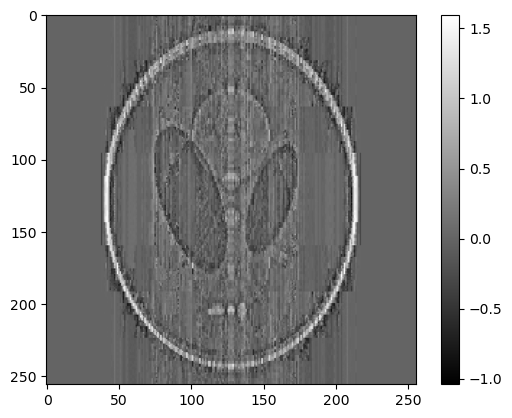

In [203]:
H_new = FWHT_Subsampling(new_mask)
alpha = 0.5
new_data = alpha * palm_arguments[0] + H_new @ image
imshow(H_new.T @ new_data, cmap='gray')
colorbar();

In [204]:
def alternating_minimisation(argument1, argument2, gradient1, gradient2, step_sizes, \
                                no_of_iterations=1000, print_output=10000):
    gradient_norm = []
    for counter in range(no_of_iterations):
        gradient_1 = gradient1([argument1, argument2])
        argument1 -= step_sizes[0] * gradient_1
        gradient_2 = gradient2([argument1, argument2])
        argument2 -= step_sizes[1] * gradient_2
        gradient_norm.append(1/2*(norm(gradient_1) + norm(gradient_2)))
        counter += 1
        if counter % print_output == 0:
            print("Iteration no. {i}/{m}, gradient norm = {g}.".format(i = counter, \
                    m=no_of_iterations, g=gradient_norm[-1]))
    return argument1, argument2, gradient_norm

In [205]:
step_sizes = [1, 1/9]
new_bregman_gradient_1 = lambda arguments: H_new @ (H_new.T @ arguments[0] - G.T @ arguments[1])
new_bregman_gradient_2 = lambda arguments: G @ (G.T @ arguments[1] - H_new.T @ arguments[0]) + \
                        proximal_map(arguments[1] + finite_difference_image) - finite_difference_image
no_of_iterations = 2500
new_argument1, new_argument2, gradient_norm = alternating_minimisation(palm_arguments[0], \
                                        palm_arguments[1], new_bregman_gradient_1, \
                                        new_bregman_gradient_2, step_sizes, no_of_iterations, \
                                        print_output=100)

Iteration no. 100/1000, gradient norm = 0.8362017588240054.
Iteration no. 200/1000, gradient norm = 0.5155132344853761.
Iteration no. 300/1000, gradient norm = 0.38813091856541504.
Iteration no. 400/1000, gradient norm = 0.3174491277821443.
Iteration no. 500/1000, gradient norm = 0.2709581072593354.
Iteration no. 600/1000, gradient norm = 0.23817803010040345.
Iteration no. 700/1000, gradient norm = 0.2135350857386628.
Iteration no. 800/1000, gradient norm = 0.19428958418127168.
Iteration no. 900/1000, gradient norm = 0.17862689182812758.
Iteration no. 1000/1000, gradient norm = 0.16569125942620422.


1102.2827793036988


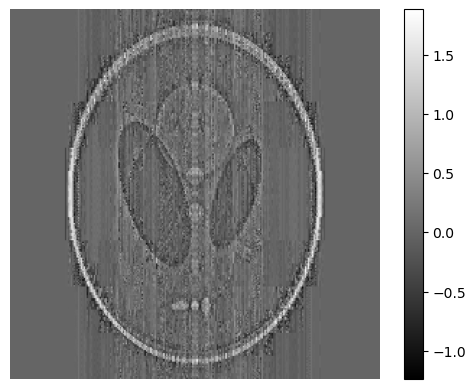

In [206]:
print(norm(new_argument1.reshape(-1)))
new_data = alpha * new_argument1 + H_new @ image
imshow(H_new.T @ new_data, cmap='gray')
colorbar();
ax = gca()
ax.set_axis_off()
# Save image
if example == 'shepp_logan':
    path = 'Data/Images/2DSC/shepp_logan_sparse_rc_data_backprojection.png'
if example == 'astronaut':
    path = 'Data/Images/2DSC/astronaut_sparse_rc_data_backprojection.png'
savefig(path, dpi=None, facecolor='w', edgecolor='w',
        orientation='portrait', format='png',
        transparent=False, bbox_inches='tight', pad_inches=0.1)

In [207]:
step_sizes = [1/8, 1]
primal_proximal_map = lambda argument : subsampled_fourier_prox(argument, new_mask, H, new_data, \
                                            step_sizes[0]/alpha)
dual_proximal_map = lambda argument : l2ball_projection(argument, axis=2)
proximal_maps = [primal_proximal_map, dual_proximal_map]    
initial_arguments = [zeros_like(image), zeros_like(palm_arguments[1])]
max_no_of_iterations=2500
tolerance=1e-6
print_output=100
new_arguments, norm_list = PDHG(G, proximal_maps, initial_arguments, step_sizes, \
                            max_no_of_iterations, print_output, tolerance)

Iteration 100/1000, sensitivity = 0.014788839056541936.
Iteration 200/1000, sensitivity = 0.005230372451823933.
Iteration 300/1000, sensitivity = 0.0025931921939983805.
Iteration 400/1000, sensitivity = 0.0017786922401260286.
Iteration 500/1000, sensitivity = 0.0013598256402865413.
Iteration 600/1000, sensitivity = 0.0011088720012473268.
Iteration 700/1000, sensitivity = 0.0008820648362859591.
Iteration 800/1000, sensitivity = 0.0007817609596350364.
Iteration 900/1000, sensitivity = 0.0005676818145953417.
Iteration 1000/1000, sensitivity = 0.0005381408697100102.
Iteration completed after 1000/1000, sensitivity = 0.0005381408697100102.


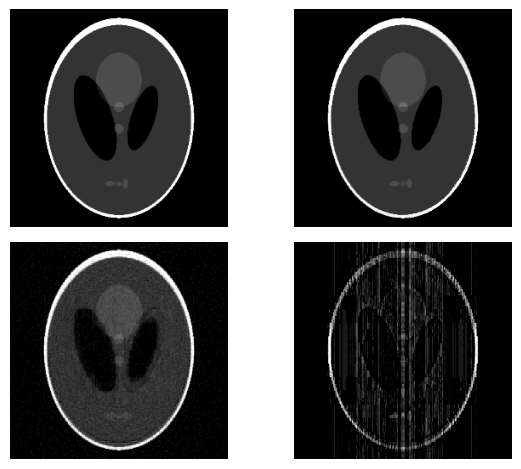

In [208]:
test3 = H_new.T @ (H_new @ image)
subplot(2, 2, 1)
imshow(image, cmap='gray', vmin=0, vmax=1)
ax = gca()
ax.set_axis_off()
subplot(2, 2, 2)
imshow(new_arguments[0], cmap='gray', vmin=0, vmax=1)
ax = gca()
ax.set_axis_off()
subplot(2, 2, 3)
imshow(test2, cmap='gray', vmin=0, vmax=1)
ax = gca()
ax.set_axis_off()
subplot(2, 2, 4)
imshow(test3, cmap='gray', vmin=0, vmax=1)
ax = gca()
ax.set_axis_off()
tight_layout();
# Save image
if example == 'shepp_logan':
    path = 'Data/Images/2DSC/shepp_logan_sparse_sanity_check.png'
if example == 'astronaut':
    path = 'Data/Images/2DSC/astronaut_sparse_sanity_check.png'
savefig(path, dpi=None, facecolor='w', edgecolor='w',
        orientation='portrait', format='png',
        transparent=False, bbox_inches='tight', pad_inches=0.1)

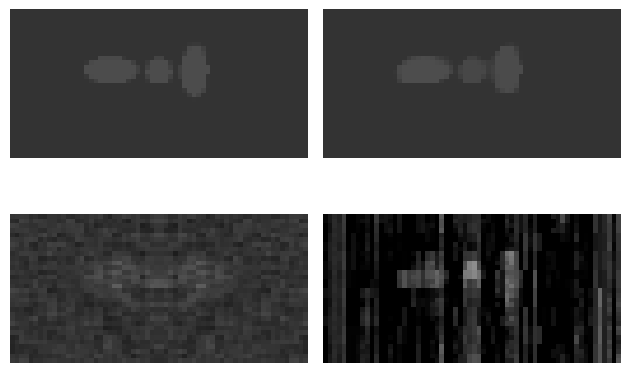

In [210]:
if example == 'shepp_logan':
    window = (slice(192, 224), slice(96, 160))
if example == 'astronaut':
    window = (slice(50, 150), slice(200, 300))
subplot(2, 2, 1)
imshow(image[window], cmap='gray', vmin=0, vmax=1)
ax = gca()
ax.set_axis_off()
subplot(2, 2, 2)
imshow(new_arguments[0][window], cmap='gray', vmin=0, vmax=1)
ax = gca()
ax.set_axis_off()
subplot(2, 2, 3)
imshow(test2[window], cmap='gray', vmin=0, vmax=1)
ax = gca()
ax.set_axis_off()
subplot(2, 2, 4)
imshow(test3[window], cmap='gray', vmin=0, vmax=1)
ax = gca()
ax.set_axis_off()
tight_layout();
# Save image
if example == 'shepp_logan':
    path = 'Data/Images/2DSC/shepp_logan_sparse_sanity_check_closeup.png'
if example == 'astronaut':
    path = 'Data/Images/2DSC/astronaut_sparse_sanity_check_closeup.png'
savefig(path, dpi=None, facecolor='w', edgecolor='w',
        orientation='portrait', format='png',
        transparent=False, bbox_inches='tight', pad_inches=0.1)